In [2]:
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import map_coordinates
from scipy.ndimage import gaussian_filter
from tqdm import tqdm
import os

2024-12-01 00:36:19.459889: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1733031379.477709  518456 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1733031379.482055  518456 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-01 00:36:19.500270: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
# Load MNIST dataset
mnist = tf.keras.datasets.mnist
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0

In [4]:
def batch_elastic_transform(images, sigma, alpha, height, width, random_state=None):
    """
    Elastic deformation of images as described in [Simard 2003].
    
    Args:
        images: a two-dimensional numpy array; list of flattened images
        sigma: variance of the gaussian kernel
        alpha: multiplier for the displacement fields
        height: image height
        width: image width
        random_state: numpy random state object
    
    Returns:
        elastically distorted images of the same shape
    """
    assert len(images.shape) == 2
    e_images = np.empty_like(images)
    e_images[:] = images
    
    e_images = e_images.reshape(-1, height, width)
    
    if random_state is None:
        random_state = np.random.RandomState(None)
    x, y = np.mgrid[0:height, 0:width]
    
    for i in range(e_images.shape[0]):
        dx = gaussian_filter((random_state.rand(height, width) * 2 - 1), 
                           sigma, mode='constant') * alpha
        dy = gaussian_filter((random_state.rand(height, width) * 2 - 1), 
                           sigma, mode='constant') * alpha
        indices = x + dx, y + dy
        e_images[i] = map_coordinates(e_images[i], indices, order=1)

    return e_images.reshape(-1, height*width)

In [5]:
random_state = np.random.RandomState(None)
dx1 = random_state.rand(28, 28) * 2 - 1
dy1 = random_state.rand(28, 28) * 2 - 1
dx2 = gaussian_filter(dx1, 4, mode='constant')
dy2 = gaussian_filter(dy1, 4, mode='constant')

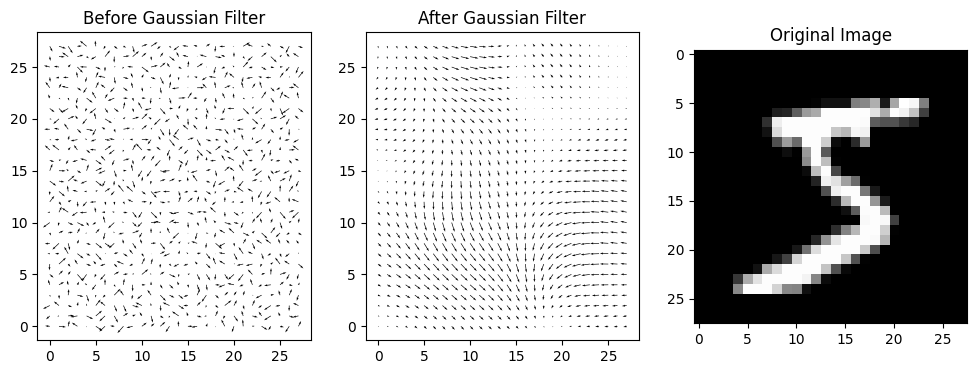

In [6]:
x, y = np.mgrid[0:28, 0:28]
    
plt.figure(figsize=(12, 4))
plt.subplot(131)
plt.quiver(x, y, dx1, dy1)
plt.title('Before Gaussian Filter')
plt.subplot(132)
plt.quiver(x, y, dx2, dy2)
plt.title('After Gaussian Filter')
# Demonstrate elastic transform on MNIST image
img = x_train[0]
plt.subplot(133)
plt.imshow(img, cmap='gray')
plt.title('Original Image')
plt.show()

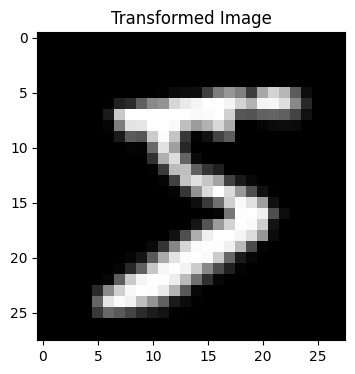

In [7]:
transformed_img = batch_elastic_transform(
    img.reshape(1, -1), 
    sigma=4, 
    alpha=20, 
    height=28, 
    width=28
)
    
plt.figure(figsize=(4, 4))
plt.imshow(transformed_img.reshape(28, 28), cmap='gray')
plt.title('Transformed Image')
plt.show()

In [8]:
def transform_dataset(x_train, batch_size=1000, sigma=4, alpha=20):
    """
    Transform entire dataset in batches to avoid memory issues
    """
    height, width = x_train.shape[1:]
    n_samples = x_train.shape[0]
    
    # Initialize array for transformed images
    transformed_images = np.zeros((n_samples, height * width))
    
    # Process in batches
    for i in tqdm(range(0, n_samples, batch_size)):
        batch_end = min(i + batch_size, n_samples)
        batch = x_train[i:batch_end]
        
        # Reshape batch to 2D array (n_samples, pixels)
        batch_flat = batch.reshape(batch_end - i, -1)
        
        # Apply transformation
        transformed = batch_elastic_transform(
            batch_flat, 
            sigma=sigma, 
            alpha=alpha,
            height=height,
            width=width
        )
        
        transformed_images[i:batch_end] = transformed
    
    return transformed_images

In [9]:
transformed_train = transform_dataset(x_train)

  0%|          | 0/60 [00:00<?, ?it/s]

100%|██████████| 60/60 [00:09<00:00,  6.27it/s]


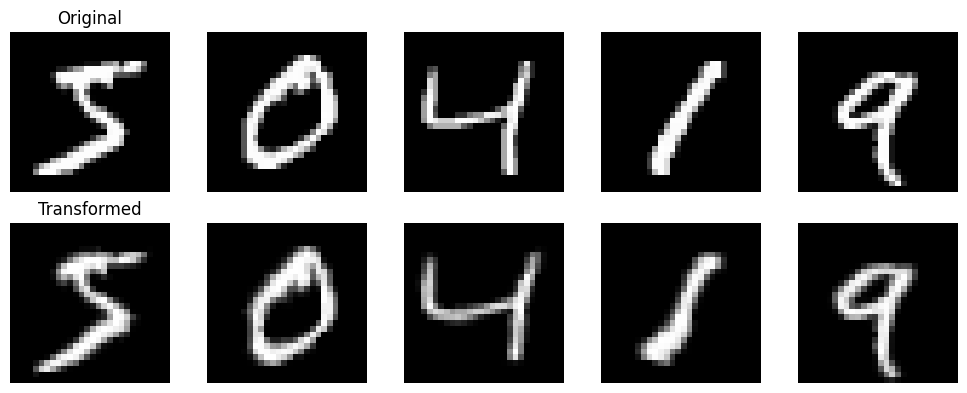

In [10]:
def plot_comparison(original, transformed, num_images=5):
    plt.figure(figsize=(2*num_images, 4))
    
    for i in range(num_images):
        # Original image
        plt.subplot(2, num_images, i + 1)
        plt.imshow(original[i], cmap='gray')
        plt.axis('off')
        if i == 0:
            plt.title('Original')
            
        # Transformed image
        plt.subplot(2, num_images, num_images + i + 1)
        plt.imshow(transformed[i].reshape(28, 28), cmap='gray')
        plt.axis('off')
        if i == 0:
            plt.title('Transformed')
    
    plt.tight_layout()
    plt.show()

# Plot some examples
plot_comparison(x_train, transformed_train)

In [11]:
def list_of_norms(X):
    """
    Computes squared L2 norm for each vector in X.
    
    Args:
        X: tensor of shape [n, d] containing n d-dimensional vectors
    
    Returns:
        tensor of shape [n] containing squared L2 norms
    """
    return tf.reduce_sum(tf.pow(X, 2), axis=1)

In [12]:
def list_of_distances(X, Y):
    """
    Computes pairwise squared Euclidean distances between two sets of vectors.
    
    Args:
        X: tensor of shape [n, d] containing n d-dimensional vectors
        Y: tensor of shape [m, d] containing m d-dimensional vectors
    
    Returns:
        tensor of shape [n, m] containing all pairwise distances
    """
    XX = tf.reshape(list_of_norms(X), shape=(-1, 1))
    YY = tf.reshape(list_of_norms(Y), shape=(1, -1))
    output = XX + YY - 2 * tf.matmul(X, tf.transpose(Y))
    
    return output

In [13]:
class PrototypeAutoencoder(tf.keras.Model):
    def __init__(self, input_shape, n_classes, n_prototypes=15):
        super(PrototypeAutoencoder, self).__init__()
        # Network parameters
        self.n_prototypes = n_prototypes
        self.input_shape = input_shape
        self.n_classes = n_classes
        
        # Encoder layers
        self.encoder = tf.keras.Sequential([
            tf.keras.layers.InputLayer(input_shape=input_shape),
            tf.keras.layers.Conv2D(32, 3, strides=2, padding='same', activation='relu'),
            tf.keras.layers.Conv2D(32, 3, strides=2, padding='same', activation='relu'),
            tf.keras.layers.Conv2D(32, 3, strides=2, padding='same', activation='relu'),
            tf.keras.layers.Conv2D(10, 3, strides=1, padding='same', activation='relu'),
            tf.keras.layers.Flatten()
        ])
        
        # Decoder layers
        self.decoder = tf.keras.Sequential([
            tf.keras.layers.InputLayer(shape=(160,)),
            tf.keras.layers.Dense(4*4*10),
            tf.keras.layers.Reshape((4, 4, 10)),
            tf.keras.layers.Conv2DTranspose(32, 3, strides=1, padding='valid', activation='relu'),  # 4x4x32
            tf.keras.layers.Conv2DTranspose(32, 3, strides=2, padding='same', activation='relu'),  # 8x8x32
            tf.keras.layers.Conv2DTranspose(32, 3, strides=1, padding='valid', activation='relu'),  # 14x14x32
            tf.keras.layers.Conv2DTranspose(1, 3, strides=2, padding='same', activation='sigmoid') # 28x28x1
        ])
        
        # Prototype vectors
        self.prototype_vectors = tf.Variable(
            tf.random.uniform(shape=[n_prototypes, 4*4*10], dtype=tf.float32),
            name='prototype_vectors'
        )
        
        # Classification layer
        self.classifier = tf.keras.layers.Dense(n_classes)

        print(self.encoder.summary())
        print(self.decoder.summary())


    def call(self, inputs):
        # Ensure input shape is correct
        if len(inputs.shape) == 2:
            inputs = tf.reshape(inputs, [-1, 28, 28, 1])
            
        # Encode
        features = self.encoder(inputs)
        
        # Calculate distances to prototypes
        prototype_distances = list_of_distances(features, self.prototype_vectors)
        
        # Get logits
        logits = self.classifier(prototype_distances)
        
        # Decode
        decoded = self.decoder(features)
        
        return logits, decoded, features, prototype_distances

In [14]:
def train_step(model, optimizer, x, y, lambda_params):
    with tf.GradientTape() as tape:
        # Forward pass
        x = tf.reshape(x, [-1, 28, 28, 1])
        logits, decoded, features, prototype_distances = model(x)

        # Calculate losses
        classification_loss = tf.reduce_mean(
            tf.keras.losses.categorical_crossentropy(y, logits, from_logits=True)
        )
        x_flat = tf.reshape(x, [-1, 784])
        decoded_flat = tf.reshape(decoded, [-1, 784])
        
        reconstruction_loss = tf.reduce_mean(
            tf.keras.losses.binary_crossentropy(x_flat, decoded_flat)
        )
        
        # Prototype losses
        feature_distances = list_of_distances(model.prototype_vectors, features)
        error_1 = tf.reduce_mean(tf.reduce_min(feature_distances, axis=1))
        error_2 = tf.reduce_mean(tf.reduce_min(prototype_distances, axis=1))
        
        # Total loss
        total_loss = (lambda_params['class'] * classification_loss + 
                     lambda_params['ae'] * reconstruction_loss +
                     lambda_params['1'] * error_1 +
                     lambda_params['2'] * error_2)
    
    # Backpropagation
    gradients = tape.gradient(total_loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    return {
        'classification': classification_loss,
        'reconstruction': reconstruction_loss,
        'error_1': error_1,
        'error_2': error_2,
        'total': total_loss
    }

In [22]:
def visualize_reconstructions(model, dataset):
    # Get multiple batches of images and select diverse samples
    sample_images = []
    for x_batch, _ in dataset.take(5):
        # Select 2 random images from each batch
        indices = tf.random.shuffle(tf.range(x_batch.shape[0]))[:2]
        sample_images.extend(tf.gather(x_batch, indices))
        if len(sample_images) >= 10:
            break
    
    sample_images = tf.stack(sample_images[:10])
    sample_images = tf.reshape(sample_images, [-1, 28, 28, 1])  # Ensure 4D shape
    
    # Reconstruct images
    _, reconstructed, _, _ = model(sample_images)
    
    # Plot results
    fig, axes = plt.subplots(2, 10, figsize=(20, 4))
    plt.suptitle('Original Images (top) vs Reconstructed Images (bottom)', y=1.05)
    
    for i in range(10):
        # Ensure proper shape for visualization
        orig_img = tf.squeeze(sample_images[i]).numpy()
        recon_img = tf.squeeze(reconstructed[i]).numpy()
        
        axes[0, i].imshow(orig_img, cmap='gray')
        axes[0, i].axis('off')
        axes[1, i].imshow(recon_img, cmap='gray')
        axes[1, i].axis('off')
    
    plt.tight_layout()
    plt.show()

In [16]:
def train_model(model, train_dataset, valid_dataset, test_dataset, epochs=1500, 
                learning_rate=0.002, batch_size=250, log_dir="logs"):
    
    optimizer = tf.keras.optimizers.Adam(learning_rate)
    lambda_params = {'class': 20, 'ae': 1, '1': 1, '2': 1}
    
    for epoch in range(epochs):
        print(f"Epoch {epoch+1}/{epochs} ")
        
        # Training loop
        for x_batch, y_batch in train_dataset:
            # Apply elastic transform
            x_batch = tf.reshape(x_batch, [-1, 28, 28, 1])
            x_flat = tf.reshape(x_batch, [-1, 784])
            x_batch_elastic = batch_elastic_transform(x_flat, sigma=4, alpha=20, 
                                                    height=28, width=28)
            losses = train_step(model, optimizer, x_batch_elastic, y_batch, lambda_params)
            
        # Validation
        val_accuracy = tf.keras.metrics.CategoricalAccuracy()
        for x_val, y_val in valid_dataset:
            logits, _, _, _ = model(x_val)
            val_accuracy.update_state(y_val, logits)
            
        print(f"Validation accuracy: {val_accuracy.result():.4f}, Loss: {losses}\n")

In [17]:
y_train = tf.keras.utils.to_categorical(y_train, 10)
y_test = tf.keras.utils.to_categorical(y_test, 10)

In [18]:
# Create datasets
train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train)).batch(250)
valid_dataset = tf.data.Dataset.from_tensor_slices((x_test[:5000], y_test[:5000])).batch(250)
test_dataset = tf.data.Dataset.from_tensor_slices((x_test[5000:], y_test[5000:])).batch(250)

I0000 00:00:1733031395.038777  518456 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 602 MB memory:  -> device: 0, name: NVIDIA A40, pci bus id: 0000:01:00.0, compute capability: 8.6
I0000 00:00:1733031395.041423  518456 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 42768 MB memory:  -> device: 1, name: NVIDIA A40, pci bus id: 0000:23:00.0, compute capability: 8.6
I0000 00:00:1733031395.043921  518456 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:2 with 42770 MB memory:  -> device: 2, name: NVIDIA A40, pci bus id: 0000:41:00.0, compute capability: 8.6
I0000 00:00:1733031395.046105  518456 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:3 with 42766 MB memory:  -> device: 3, name: NVIDIA A40, pci bus id: 0000:61:00.0, compute capability: 8.6
I0000 00:00:1733031395.048194  518456 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/devic

In [19]:
# Create and train model
model = PrototypeAutoencoder(input_shape=(28, 28, 1), n_classes=10, n_prototypes=15)

/u/prebello/dls/lib/python3.10/site-packages/keras/src/layers/core/input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 14, 14, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 7, 7, 32)       │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 4, 4, 32)       │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 4, 4, 10)       │         2,890 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 160)            │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 21,706 (84.79 KB)

 Trainable params: 21,706 (84.79 KB)

 Non-trainable params: 0 (0.00 B)

None


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 160)            │        25,760 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 4, 4, 10)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose                │ (None, 6, 6, 32)       │         2,912 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_1              │ (None, 12, 12, 32)     │         9,248 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_2              │ (None, 14, 14, 32)     │         9,248 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_3              │ (None, 28, 28, 1)      │           289 │
│ (Conv2DTranspose)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 47,457 (185.38 KB)

 Trainable params: 47,457 (185.38 KB)

 Non-trainable params: 0 (0.00 B)

None


In [20]:
train_model(model, train_dataset, valid_dataset, test_dataset)

Epoch 1/1500 


I0000 00:00:1733031396.798051  518456 cuda_dnn.cc:529] Loaded cuDNN version 90400
2024-12-01 00:36:37.582197: W external/local_xla/xla/tsl/framework/bfc_allocator.cc:306] Allocator (GPU_0_bfc) ran out of memory trying to allocate 127.89MiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2024-12-01 00:36:37.583227: W external/local_xla/xla/tsl/framework/bfc_allocator.cc:306] Allocator (GPU_0_bfc) ran out of memory trying to allocate 128.08MiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2024-12-01 00:36:38.923586: W external/local_xla/xla/tsl/framework/bfc_allocator.cc:306] Allocator (GPU_0_bfc) ran out of memory trying to allocate 97.07MiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains

Validation accuracy: 0.8198, Loss: {'classification': <tf.Tensor: shape=(), dtype=float32, numpy=0.6777575016021729>, 'reconstruction': <tf.Tensor: shape=(), dtype=float32, numpy=0.2285607010126114>, 'error_1': <tf.Tensor: shape=(), dtype=float32, numpy=14.290221214294434>, 'error_2': <tf.Tensor: shape=(), dtype=float32, numpy=8.207448959350586>, 'total': <tf.Tensor: shape=(), dtype=float32, numpy=36.28137969970703>}

Epoch 2/1500 


2024-12-01 00:37:38.150761: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Validation accuracy: 0.9118, Loss: {'classification': <tf.Tensor: shape=(), dtype=float32, numpy=0.3752032518386841>, 'reconstruction': <tf.Tensor: shape=(), dtype=float32, numpy=0.16014862060546875>, 'error_1': <tf.Tensor: shape=(), dtype=float32, numpy=14.322263717651367>, 'error_2': <tf.Tensor: shape=(), dtype=float32, numpy=6.4113898277282715>, 'total': <tf.Tensor: shape=(), dtype=float32, numpy=28.39786720275879>}

Epoch 3/1500 
Validation accuracy: 0.9302, Loss: {'classification': <tf.Tensor: shape=(), dtype=float32, numpy=0.24260534346103668>, 'reconstruction': <tf.Tensor: shape=(), dtype=float32, numpy=0.1541486233472824>, 'error_1': <tf.Tensor: shape=(), dtype=float32, numpy=13.624587059020996>, 'error_2': <tf.Tensor: shape=(), dtype=float32, numpy=5.507785797119141>, 'total': <tf.Tensor: shape=(), dtype=float32, numpy=24.138628005981445>}

Epoch 4/1500 


2024-12-01 00:38:37.316867: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Validation accuracy: 0.9458, Loss: {'classification': <tf.Tensor: shape=(), dtype=float32, numpy=0.1874133199453354>, 'reconstruction': <tf.Tensor: shape=(), dtype=float32, numpy=0.15327462553977966>, 'error_1': <tf.Tensor: shape=(), dtype=float32, numpy=13.025358200073242>, 'error_2': <tf.Tensor: shape=(), dtype=float32, numpy=5.000993728637695>, 'total': <tf.Tensor: shape=(), dtype=float32, numpy=21.927892684936523>}

Epoch 5/1500 
Validation accuracy: 0.9538, Loss: {'classification': <tf.Tensor: shape=(), dtype=float32, numpy=0.16704317927360535>, 'reconstruction': <tf.Tensor: shape=(), dtype=float32, numpy=0.15336279571056366>, 'error_1': <tf.Tensor: shape=(), dtype=float32, numpy=12.350687980651855>, 'error_2': <tf.Tensor: shape=(), dtype=float32, numpy=4.701602458953857>, 'total': <tf.Tensor: shape=(), dtype=float32, numpy=20.54651641845703>}

Epoch 6/1500 
Validation accuracy: 0.9596, Loss: {'classification': <tf.Tensor: shape=(), dtype=float32, numpy=0.14232410490512848>, 'reco

2024-12-01 00:40:35.675504: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Validation accuracy: 0.9630, Loss: {'classification': <tf.Tensor: shape=(), dtype=float32, numpy=0.14508207142353058>, 'reconstruction': <tf.Tensor: shape=(), dtype=float32, numpy=0.15641212463378906>, 'error_1': <tf.Tensor: shape=(), dtype=float32, numpy=11.919087409973145>, 'error_2': <tf.Tensor: shape=(), dtype=float32, numpy=4.0554118156433105>, 'total': <tf.Tensor: shape=(), dtype=float32, numpy=19.03255271911621>}

Epoch 9/1500 
Validation accuracy: 0.9666, Loss: {'classification': <tf.Tensor: shape=(), dtype=float32, numpy=0.15882596373558044>, 'reconstruction': <tf.Tensor: shape=(), dtype=float32, numpy=0.16106243431568146>, 'error_1': <tf.Tensor: shape=(), dtype=float32, numpy=11.38233470916748>, 'error_2': <tf.Tensor: shape=(), dtype=float32, numpy=4.1432271003723145>, 'total': <tf.Tensor: shape=(), dtype=float32, numpy=18.863143920898438>}

Epoch 10/1500 
Validation accuracy: 0.9658, Loss: {'classification': <tf.Tensor: shape=(), dtype=float32, numpy=0.13906404376029968>, 'r

2024-12-01 00:44:32.289617: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Validation accuracy: 0.9676, Loss: {'classification': <tf.Tensor: shape=(), dtype=float32, numpy=0.10312642902135849>, 'reconstruction': <tf.Tensor: shape=(), dtype=float32, numpy=0.16454486548900604>, 'error_1': <tf.Tensor: shape=(), dtype=float32, numpy=10.101367950439453>, 'error_2': <tf.Tensor: shape=(), dtype=float32, numpy=3.8557724952697754>, 'total': <tf.Tensor: shape=(), dtype=float32, numpy=16.184213638305664>}

Epoch 17/1500 
Validation accuracy: 0.9670, Loss: {'classification': <tf.Tensor: shape=(), dtype=float32, numpy=0.11554724723100662>, 'reconstruction': <tf.Tensor: shape=(), dtype=float32, numpy=0.157262921333313>, 'error_1': <tf.Tensor: shape=(), dtype=float32, numpy=10.619903564453125>, 'error_2': <tf.Tensor: shape=(), dtype=float32, numpy=3.745434045791626>, 'total': <tf.Tensor: shape=(), dtype=float32, numpy=16.833545684814453>}

Epoch 18/1500 
Validation accuracy: 0.9702, Loss: {'classification': <tf.Tensor: shape=(), dtype=float32, numpy=0.10108919441699982>, 'r

2024-12-01 00:52:23.641654: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Validation accuracy: 0.9736, Loss: {'classification': <tf.Tensor: shape=(), dtype=float32, numpy=0.09177093952894211>, 'reconstruction': <tf.Tensor: shape=(), dtype=float32, numpy=0.15970608592033386>, 'error_1': <tf.Tensor: shape=(), dtype=float32, numpy=8.85696792602539>, 'error_2': <tf.Tensor: shape=(), dtype=float32, numpy=3.3008594512939453>, 'total': <tf.Tensor: shape=(), dtype=float32, numpy=14.152952194213867>}

Epoch 33/1500 
Validation accuracy: 0.9730, Loss: {'classification': <tf.Tensor: shape=(), dtype=float32, numpy=0.10581207275390625>, 'reconstruction': <tf.Tensor: shape=(), dtype=float32, numpy=0.15730828046798706>, 'error_1': <tf.Tensor: shape=(), dtype=float32, numpy=7.553914546966553>, 'error_2': <tf.Tensor: shape=(), dtype=float32, numpy=3.3360023498535156>, 'total': <tf.Tensor: shape=(), dtype=float32, numpy=13.163466453552246>}

Epoch 34/1500 
Validation accuracy: 0.9720, Loss: {'classification': <tf.Tensor: shape=(), dtype=float32, numpy=0.08279801905155182>, 'r

2024-12-01 01:08:01.485603: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Validation accuracy: 0.9752, Loss: {'classification': <tf.Tensor: shape=(), dtype=float32, numpy=0.07504132390022278>, 'reconstruction': <tf.Tensor: shape=(), dtype=float32, numpy=0.15688353776931763>, 'error_1': <tf.Tensor: shape=(), dtype=float32, numpy=5.40032434463501>, 'error_2': <tf.Tensor: shape=(), dtype=float32, numpy=2.7209181785583496>, 'total': <tf.Tensor: shape=(), dtype=float32, numpy=9.778952598571777>}

Epoch 65/1500 
Validation accuracy: 0.9782, Loss: {'classification': <tf.Tensor: shape=(), dtype=float32, numpy=0.10730903595685959>, 'reconstruction': <tf.Tensor: shape=(), dtype=float32, numpy=0.1613720953464508>, 'error_1': <tf.Tensor: shape=(), dtype=float32, numpy=6.5627264976501465>, 'error_2': <tf.Tensor: shape=(), dtype=float32, numpy=2.5152664184570312>, 'total': <tf.Tensor: shape=(), dtype=float32, numpy=11.38554573059082>}

Epoch 66/1500 
Validation accuracy: 0.9796, Loss: {'classification': <tf.Tensor: shape=(), dtype=float32, numpy=0.10879290848970413>, 'rec

2024-12-01 01:39:02.229151: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Validation accuracy: 0.9750, Loss: {'classification': <tf.Tensor: shape=(), dtype=float32, numpy=0.10630413889884949>, 'reconstruction': <tf.Tensor: shape=(), dtype=float32, numpy=0.16308265924453735>, 'error_1': <tf.Tensor: shape=(), dtype=float32, numpy=5.993488788604736>, 'error_2': <tf.Tensor: shape=(), dtype=float32, numpy=2.0686097145080566>, 'total': <tf.Tensor: shape=(), dtype=float32, numpy=10.351263046264648>}

Epoch 129/1500 
Validation accuracy: 0.9764, Loss: {'classification': <tf.Tensor: shape=(), dtype=float32, numpy=0.10077473521232605>, 'reconstruction': <tf.Tensor: shape=(), dtype=float32, numpy=0.16084811091423035>, 'error_1': <tf.Tensor: shape=(), dtype=float32, numpy=5.697659015655518>, 'error_2': <tf.Tensor: shape=(), dtype=float32, numpy=1.9801855087280273>, 'total': <tf.Tensor: shape=(), dtype=float32, numpy=9.85418701171875>}

Epoch 130/1500 
Validation accuracy: 0.9780, Loss: {'classification': <tf.Tensor: shape=(), dtype=float32, numpy=0.1143222525715828>, 'r

2024-12-01 02:41:02.071788: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Validation accuracy: 0.9802, Loss: {'classification': <tf.Tensor: shape=(), dtype=float32, numpy=0.06529159098863602>, 'reconstruction': <tf.Tensor: shape=(), dtype=float32, numpy=0.16007712483406067>, 'error_1': <tf.Tensor: shape=(), dtype=float32, numpy=3.6007730960845947>, 'error_2': <tf.Tensor: shape=(), dtype=float32, numpy=2.0131497383117676>, 'total': <tf.Tensor: shape=(), dtype=float32, numpy=7.079831600189209>}

Epoch 257/1500 
Validation accuracy: 0.9780, Loss: {'classification': <tf.Tensor: shape=(), dtype=float32, numpy=0.08856412768363953>, 'reconstruction': <tf.Tensor: shape=(), dtype=float32, numpy=0.16202618181705475>, 'error_1': <tf.Tensor: shape=(), dtype=float32, numpy=2.9899022579193115>, 'error_2': <tf.Tensor: shape=(), dtype=float32, numpy=2.1402385234832764>, 'total': <tf.Tensor: shape=(), dtype=float32, numpy=7.063449859619141>}

Epoch 258/1500 
Validation accuracy: 0.9740, Loss: {'classification': <tf.Tensor: shape=(), dtype=float32, numpy=0.09397163987159729>,

2024-12-01 04:44:33.783872: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Validation accuracy: 0.9810, Loss: {'classification': <tf.Tensor: shape=(), dtype=float32, numpy=0.07213769108057022>, 'reconstruction': <tf.Tensor: shape=(), dtype=float32, numpy=0.16226594150066376>, 'error_1': <tf.Tensor: shape=(), dtype=float32, numpy=2.2237563133239746>, 'error_2': <tf.Tensor: shape=(), dtype=float32, numpy=1.706783413887024>, 'total': <tf.Tensor: shape=(), dtype=float32, numpy=5.535559177398682>}

Epoch 513/1500 
Validation accuracy: 0.9806, Loss: {'classification': <tf.Tensor: shape=(), dtype=float32, numpy=0.10306931287050247>, 'reconstruction': <tf.Tensor: shape=(), dtype=float32, numpy=0.1588229238986969>, 'error_1': <tf.Tensor: shape=(), dtype=float32, numpy=3.8984105587005615>, 'error_2': <tf.Tensor: shape=(), dtype=float32, numpy=1.6375041007995605>, 'total': <tf.Tensor: shape=(), dtype=float32, numpy=7.756124019622803>}

Epoch 514/1500 
Validation accuracy: 0.9756, Loss: {'classification': <tf.Tensor: shape=(), dtype=float32, numpy=0.06744362413883209>, '

2024-12-01 08:52:20.068997: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Validation accuracy: 0.9796, Loss: {'classification': <tf.Tensor: shape=(), dtype=float32, numpy=0.07830805331468582>, 'reconstruction': <tf.Tensor: shape=(), dtype=float32, numpy=0.1605456918478012>, 'error_1': <tf.Tensor: shape=(), dtype=float32, numpy=2.8242056369781494>, 'error_2': <tf.Tensor: shape=(), dtype=float32, numpy=1.653564214706421>, 'total': <tf.Tensor: shape=(), dtype=float32, numpy=6.204476356506348>}

Epoch 1025/1500 
Validation accuracy: 0.9774, Loss: {'classification': <tf.Tensor: shape=(), dtype=float32, numpy=0.09202651679515839>, 'reconstruction': <tf.Tensor: shape=(), dtype=float32, numpy=0.1592283993959427>, 'error_1': <tf.Tensor: shape=(), dtype=float32, numpy=3.5029728412628174>, 'error_2': <tf.Tensor: shape=(), dtype=float32, numpy=1.670961856842041>, 'total': <tf.Tensor: shape=(), dtype=float32, numpy=7.173693656921387>}

Epoch 1026/1500 
Validation accuracy: 0.9806, Loss: {'classification': <tf.Tensor: shape=(), dtype=float32, numpy=0.08180023729801178>, '

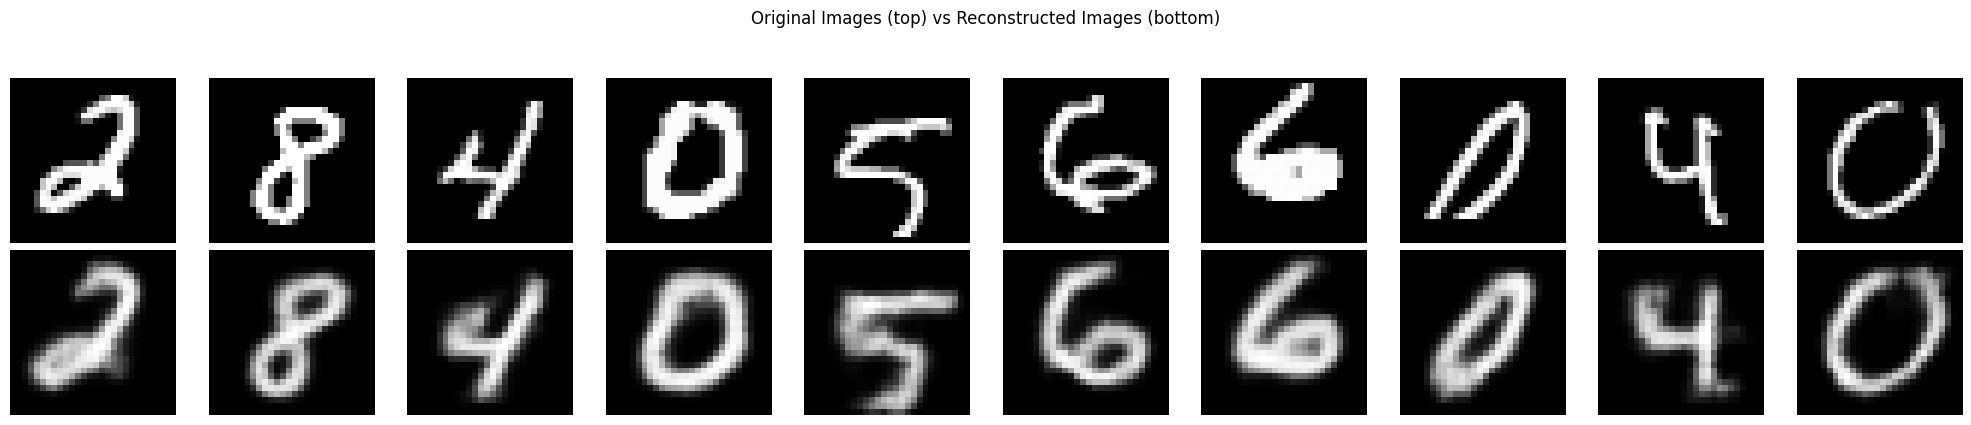

In [23]:
visualize_reconstructions(model, train_dataset)

In [25]:
# After training is complete
model.save("mnist_prototype_model.h5")

In [28]:
def visualize_weight_matrix(model):
    # Get the weights from the classifier layer (prototype to class weights)
    weights = model.classifier.get_weights()[0]  # Shape: [n_prototypes, n_classes]
    
    # Create figure
    fig, ax = plt.subplots(figsize=(12, 8))
    
    # Display the weight matrix
    im = ax.imshow(weights, cmap='RdBu_r')
    
    # Set labels
    class_names = [str(i) for i in range(10)]  # MNIST digits 0-9
    
    # Add colorbar
    plt.colorbar(im)
    
    # Configure axes
    ax.set_xticks(np.arange(len(class_names)))
    ax.set_xticklabels(class_names)
    ax.set_xlabel('Digit Classes')
    ax.set_ylabel('Prototypes')
    
    # Add numbers in cells
    for i in range(weights.shape[0]):
        for j in range(weights.shape[1]):
            text = ax.text(j, i, f'{weights[i, j]:.2f}',
                         ha="center", va="center", 
                         color="black" if abs(weights[i, j]) < 10 else "white")
    
    plt.title("Prototype-to-Class Weight Matrix")
    plt.tight_layout()
    plt.show()

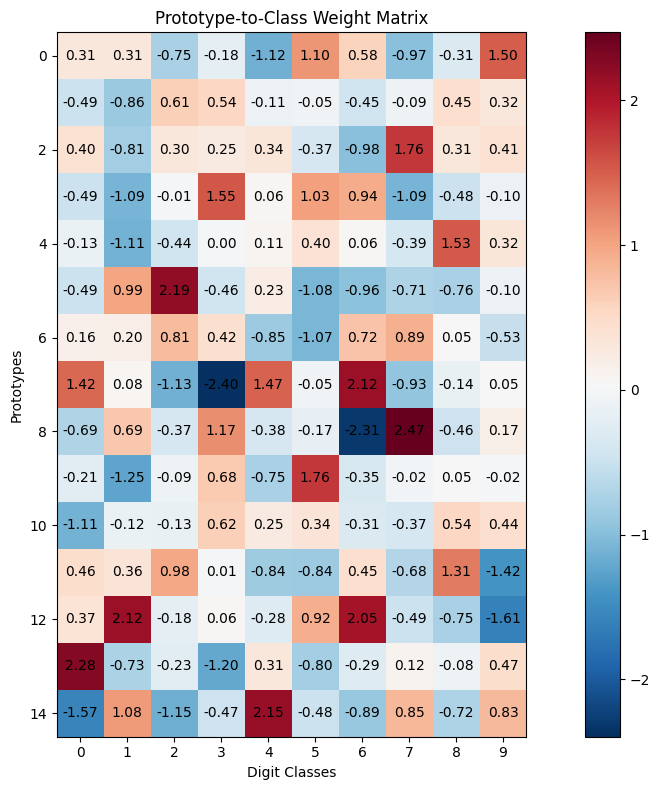

In [29]:
# After training the model
visualize_weight_matrix(model)

In [32]:
def visualize_image_class_weights(model, dataset):
    # Get one sample image from each class
    images_by_class = [[] for _ in range(10)]
    for x_batch, y_batch in dataset:
        y_labels = tf.argmax(y_batch, axis=1)
        for img, label in zip(x_batch, y_labels):
            images_by_class[label.numpy()].append(img)
        if all(len(c) > 0 for c in images_by_class):
            break
    
    # Select first image from each class
    sample_images = [class_images[0] for class_images in images_by_class]
    sample_images = tf.stack(sample_images)
    
    # Get logits through the model
    logits, _, features, _ = model(sample_images)
    
    # Create figure with proper sizing
    fig = plt.figure(figsize=(15, 10))
    gs = plt.GridSpec(2, 1, height_ratios=[4, 1])
    
    # Plot weight matrix
    ax_weights = fig.add_subplot(gs[0])
    im = ax_weights.imshow(logits.numpy(), cmap='RdBu_r')
    plt.colorbar(im)
    
    # Add weight values in cells
    for i in range(logits.shape[0]):
        for j in range(logits.shape[1]):
            text_color = 'white' if abs(logits[i, j]) > 10 else 'black'
            ax_weights.text(j, i, f'{logits[i, j]:.2f}',
                          ha='center', va='center', color=text_color)
    
    # Plot sample digits on right side
    ax_images = fig.add_subplot(gs[1])
    for i in range(10):
        ax_images.imshow(sample_images[i], 
                        extent=[i-0.5, i+0.5, 0, 1],
                        cmap='gray')
    
    # Configure axes
    ax_weights.set_xticks(range(10))
    ax_weights.set_xticklabels(range(10))
    ax_weights.set_ylabel('Input Images')
    ax_weights.set_xlabel('Digit Classes')
    ax_images.set_xticks([])
    ax_images.set_yticks([])
    
    plt.suptitle('Image-to-Class Weight Matrix')
    plt.tight_layout()
    plt.show()

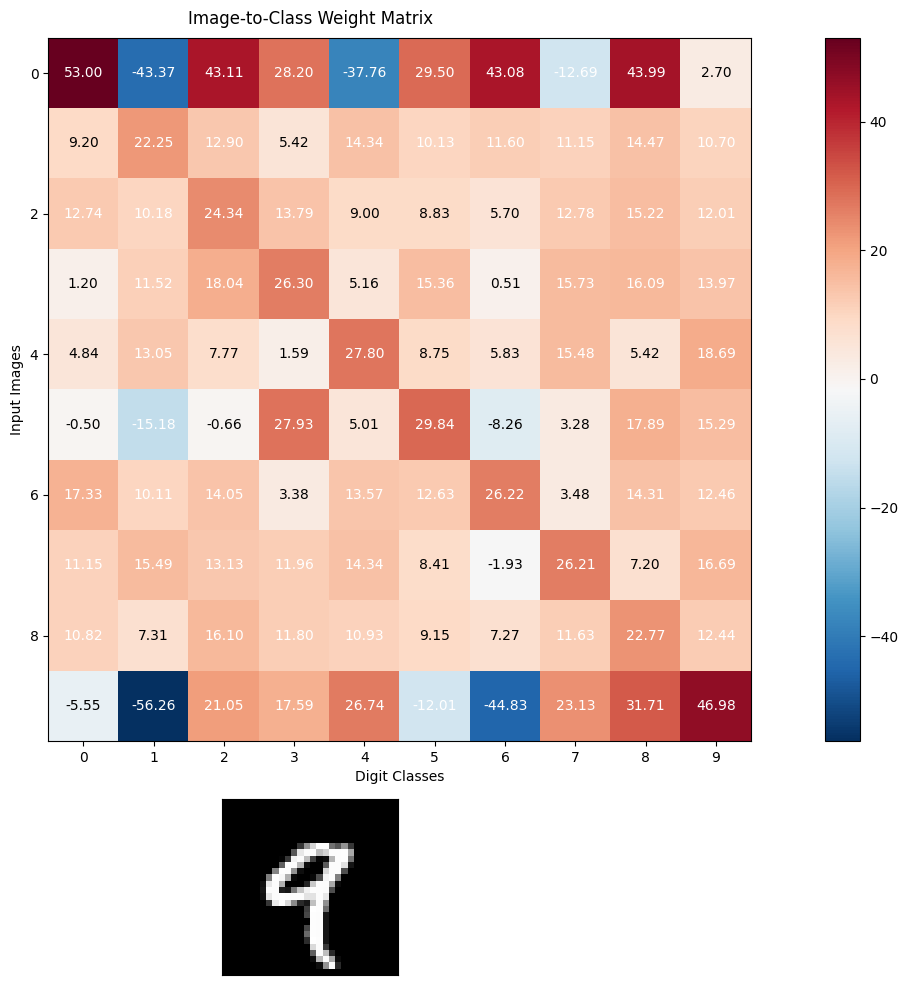

In [33]:
visualize_image_class_weights(model, train_dataset)